In [ ]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# TOKEN = user_secrets.get_secret("GITHUB_TOKEN")
#
# !git clone https://{TOKEN}@github.com/nicoloalbergoni/DeeplabV3Plus-TF2.git
# %load_ext tensorboard
# %cd ./DeeplabV3Plus-TF2

In [ ]:
#!python download_and_prepare_voc.py --remove_cmap --download_berkley

In [1]:
import os
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import pyplot as plt
from superresolution import Superresolution
from utils import get_img_paths, load_image, create_mask, plot_prediction
from model import DeeplabV3Plus
from tqdm import tqdm

In [2]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
PASCAL_ROOT = os.path.join(DATA_DIR, "VOCdevkit", "VOC2012")
IMGS_PATH = os.path.join(PASCAL_ROOT, "JPEGImages")

SUPERRES_ROOT = os.path.join(DATA_DIR, "superres_root")
PRECOMPUTED_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "precomputed_features")
STANDARD_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "standard_output")
SUPERRES_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "superres_output")

# SEED = np.random.randint(0, 1000)
SEED = 1234
IMG_SIZE = (512, 512)
BATCH_SIZE = 2
BUFFER_SIZE = 1000
EPOCHS = 30
CLASSES = 21
RESHAPE_MASKS = True
NUM_AUG = 50
CLASS_ID = 8 # Cat class
NUM_SAMPLES = 300

# Utils Functions

In [4]:
def filter_by_class(img_paths, class_id, image_size=(512, 512)):
    """
    Given a list of image paths, return the images that contain the given class id in the respective mask

    Args:
        img_paths: List of image paths to check
        class_id: Class id used for filering
        image_size: Size of the image used to load and resize the image

    Returns: A dictionary whose keys are the image filename and values are the actual images

    """
    images_dict = {}
    for img_path in img_paths:
        image_name = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = img_path.replace("JPEGImages", "SegmentationClassAug").replace("jpg", "png")
        mask = load_image(mask_path, image_size=image_size, normalize=False, is_png=True, resize_method="nearest")
        if np.any(mask == class_id):
            image = load_image(img_path, image_size=IMG_SIZE, normalize=True)
            images_dict[image_name] = image

    return images_dict

def get_prediction(model, input_image):

    prediction = model.predict(input_image[tf.newaxis, ...])
    mask = create_mask(prediction[0])

    return mask


def min_max_normalization(image, new_min=0.0, new_max=255.0, global_min=None, global_max=None):

    min = image.min() if global_min is None else global_min
    max = image.max() if global_max is None else global_max

    num = (image - min) * (new_max - new_min)
    den = max - min
    return new_min + (num / den)


In [5]:
image_list_path = os.path.join(DATA_DIR, "augmented_file_lists", "valaug.txt")
image_paths = get_img_paths(image_list_path, IMGS_PATH)

if NUM_SAMPLES is not None:
    image_paths = image_paths[:NUM_SAMPLES]

images_dict = filter_by_class(image_paths, class_id=CLASS_ID)

print(f"Valid images: {len(images_dict)} (Initial:  {len(image_paths)})")

valid_filenames = list(images_dict.keys())

model_no_upsample = DeeplabV3Plus(
    input_shape=(512, 512, 3),
    classes=21,
    OS=16,
    last_activation=None,
    load_weights=True,
    backbone="mobilenet",
    alpha=1.).build_model(final_upsample=False)

model_standard = DeeplabV3Plus(
    input_shape=(512, 512, 3),
    classes=21,
    OS=16,
    last_activation=None,
    load_weights=True,
    backbone="mobilenet",
    alpha=1.).build_model(final_upsample=True)

Valid images: 26 (Initial:  300)


# Compute standard output for comparison

In [6]:
def compute_standard_output(image_dict, model, dest_folder, filter_class_id=None):
    standard_masks = {}
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for key in tqdm(image_dict):
        standard_mask = get_prediction(model, image_dict[key])
        if filter_class_id is not None:
            standard_mask = tf.where(standard_mask == filter_class_id, standard_mask, 0) # Set to 0 all predictions different from the given class
        tf.keras.utils.save_img(f"{dest_folder}/{key}.png", standard_mask, scale=False)
        standard_masks[key] = standard_mask

    return standard_masks

In [7]:
standard_masks_dict = compute_standard_output(images_dict, model_standard, dest_folder=STANDARD_OUTPUT_DIR, filter_class_id=CLASS_ID)

100%|██████████| 26/26 [00:19<00:00,  1.32it/s]


# Precompute Augmented Output Features

In [8]:
def augment_image(image, num_aug, angle_max, shift_max):

    batched_images = tf.tile(tf.expand_dims(image, axis=0), [num_aug, 1, 1, 1])  # Size [num_aug, 512, 512, 3]
    angles = np.random.uniform(-angle_max, angle_max, num_aug)
    shifts = np.random.uniform(-shift_max, shift_max, (num_aug, 2))
    # First sample is not augmented
    angles[0] = 0
    shifts[0] = np.array([0, 0])
    angles = angles.astype("float32")
    shifts = shifts.astype("float32")

    rotated_images = tfa.image.rotate(batched_images, angles, interpolation="bilinear")
    translated_images = tfa.image.translate(rotated_images, shifts, interpolation="bilinear")

    return translated_images, angles, shifts

def compute_augmented_features(images_dict, model, dest_folder, filter_class_id=None, num_aug=100, angle_max=0.5, shift_max=30, scale=True, save_output=False):
    augmented_features = {}
    for filename in tqdm(images_dict):
        augmented_images, angles, shifts = augment_image(images_dict[filename], num_aug=num_aug, angle_max=angle_max, shift_max=shift_max)

        output_folder= os.path.join(dest_folder, filename)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        predictions = model.predict(augmented_images, batch_size=BATCH_SIZE)

        masks = []
        for i, prediction in enumerate(predictions):
            if filter_class_id is not None:
                mask = prediction[:, :, filter_class_id]
                mask = mask[:, :, np.newaxis]

                #mask = tf.nn.relu(mask)

            if scale:
                #mask = mask.numpy()
                mask = min_max_normalization(mask, new_min=0.0, new_max=255.0)

            #mask_scaled = ((mask_npy - mask_npy.min()) * (1/(mask_npy.max() - mask_npy.min()) * 255)).astype('uint8')
            if save_output:
                tf.keras.utils.save_img(f"{output_folder}/{i}.png", mask.astype('uint8'), scale=False)

            np.save(os.path.join(output_folder, f"{filename}_angles"), angles)
            np.save(os.path.join(output_folder, f"{filename}_shifts"), shifts)

            masks.append(mask)

        augmented_features[filename] = masks

    return augmented_features

In [9]:
angle_max = 0.5  # in radians
shift_max = 30

augmented_features_dict = compute_augmented_features(images_dict, model_no_upsample, dest_folder=PRECOMPUTED_OUTPUT_DIR, filter_class_id=CLASS_ID, num_aug=NUM_AUG, angle_max=angle_max, shift_max=shift_max, scale=False, save_output=False)

100%|██████████| 26/26 [01:38<00:00,  3.80s/it]


# Compute Super-Resolution Output

In [12]:
def load_images(img_folder):
    images = []
    # Sort images based on their filename which is an integer indicating the augmented copy number
    image_list = sorted([name.replace(".png", "") for name in os.listdir(img_folder) if ".npy" not in name], key=int)

    for img_name in image_list:
        if ".npy" in img_name:
            continue
        image = load_image(os.path.join(img_folder, f"{img_name}.png"), normalize=False, is_png=True)
        images.append(image)

    return images


def get_precomputed_folders_path(root_dir, num_aug=100):
    valid_folders = []
    for path in os.listdir(root_dir):
        full_path = os.path.join(root_dir, path)
        if len(os.listdir(full_path)) == (num_aug + 2):
            valid_folders.append(full_path)
        else:
            print(f"Skipped folder named {path} as it is not valid")

    return valid_folders


def compute_superresolution_output(augmented_features_dict, superresolution_obj, precomputed_root_dir, dest_folder, num_aug=100, save_output=False):

    superres_masks = {}
    losses = {}

    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for filename in tqdm(augmented_features_dict):
        augmented_features_array = augmented_features_dict[filename]

        if not len(augmented_features_array) == num_aug:
            print(f"Skipped folder named {filename} as it is not valid")
            continue

        augmented_images = tf.stack(augmented_features_array)
        # max_values = np.max(augmented_images, axis=(1, 2, 3), keepdims=True)
        # max_values[max_values == 0.] = 1.
        # augmented_images = augmented_images / max_values
        # augmented_images = tf.cast(augmented_images, tf.float32)
        global_min = tf.reduce_min(augmented_images)
        global_max = tf.reduce_max(augmented_images)
        augmented_images = tf.map_fn(fn=lambda image: min_max_normalization(image.numpy(), new_min=0.0, new_max=1.0, global_min=global_min, global_max=global_max), elems=augmented_images)

        precomputed_folder_path = os.path.join(precomputed_root_dir, filename)
        angles = np.load(os.path.join(precomputed_folder_path, f"{filename}_angles.npy"))
        shifts = np.load(os.path.join(precomputed_folder_path, f"{filename}_shifts.npy"))

        target_image, loss = superresolution_obj.compute_output(augmented_images, angles, shifts)
        target_image = (target_image[0]).numpy()

        target_image_scaled = min_max_normalization(target_image, new_min=0.0, new_max=255.0)

        if save_output:
            tf.keras.utils.save_img(f"{dest_folder}/{filename}.png", target_image_scaled.astype('uint8'), scale=False)

        superres_masks[filename] = target_image_scaled
        losses[filename] = loss

    return superres_masks, losses

In [13]:
# super resolution parameters
learning_rate = 1e-3
lambda_eng = 0.0001 * NUM_AUG
lambda_tv = 0.002 * NUM_AUG
num_iter = 400

superresolution = Superresolution(
    lambda_tv=lambda_tv,
    lambda_eng=lambda_eng,
    num_iter=num_iter,
    num_aug=NUM_AUG,
    learning_rate=learning_rate,
    verbose=False
)

superres_masks_dict, losses = compute_superresolution_output(augmented_features_dict, superresolution, precomputed_root_dir=PRECOMPUTED_OUTPUT_DIR, dest_folder=SUPERRES_OUTPUT_DIR, num_aug=NUM_AUG, save_output=True)

  4%|▍         | 1/26 [00:25<10:29, 25.19s/it]

Final loss: 8188.79150390625


  8%|▊         | 2/26 [00:40<07:48, 19.52s/it]

Final loss: 7624.35400390625


 12%|█▏        | 3/26 [00:56<06:47, 17.70s/it]

Final loss: 8790.734375


 15%|█▌        | 4/26 [01:15<06:42, 18.30s/it]

Final loss: 3868.82861328125


 19%|█▉        | 5/26 [01:33<06:20, 18.13s/it]

Final loss: 7246.04541015625


 23%|██▎       | 6/26 [01:55<06:27, 19.39s/it]

Final loss: 7422.51708984375


 27%|██▋       | 7/26 [02:14<06:05, 19.26s/it]

Final loss: 9247.7998046875


 31%|███       | 8/26 [02:31<05:34, 18.56s/it]

Final loss: 14368.8837890625


 35%|███▍      | 9/26 [02:46<04:59, 17.61s/it]

Final loss: 4543.17919921875


 38%|███▊      | 10/26 [03:02<04:31, 16.96s/it]

Final loss: 7819.8076171875


 42%|████▏     | 11/26 [03:17<04:06, 16.45s/it]

Final loss: 7408.94189453125


 46%|████▌     | 12/26 [03:33<03:46, 16.19s/it]

Final loss: 4549.97216796875


 50%|█████     | 13/26 [03:50<03:34, 16.47s/it]

Final loss: 9936.9013671875


 54%|█████▍    | 14/26 [04:07<03:19, 16.60s/it]

Final loss: 3216.147216796875


 58%|█████▊    | 15/26 [04:26<03:10, 17.32s/it]

Final loss: 24509.388671875


 62%|██████▏   | 16/26 [04:43<02:52, 17.22s/it]

Final loss: 24015.587890625


 65%|██████▌   | 17/26 [04:59<02:33, 17.00s/it]

Final loss: 11929.296875


 69%|██████▉   | 18/26 [05:15<02:12, 16.61s/it]

Final loss: 5678.8095703125


 73%|███████▎  | 19/26 [05:30<01:53, 16.25s/it]

Final loss: 7542.33349609375


 77%|███████▋  | 20/26 [05:46<01:36, 16.06s/it]

Final loss: 11935.5341796875


 81%|████████  | 21/26 [06:02<01:19, 15.99s/it]

Final loss: 6207.919921875


 85%|████████▍ | 22/26 [06:19<01:05, 16.43s/it]

Final loss: 5935.49267578125


 88%|████████▊ | 23/26 [06:37<00:50, 16.88s/it]

Final loss: 6034.21923828125


 92%|█████████▏| 24/26 [06:53<00:33, 16.58s/it]

Final loss: 14416.4423828125


 96%|█████████▌| 25/26 [07:10<00:16, 16.64s/it]

Final loss: 6678.73193359375


100%|██████████| 26/26 [07:27<00:00, 17.21s/it]

Final loss: 6141.5625


In [14]:
superres_masks_dict_th = {}

for key in superres_masks_dict:
    sample_th = tf.cast(tf.reduce_max(superres_masks_dict[key]), tf.float32) * 0.85
    th_mask = tf.where(superres_masks_dict[key] > sample_th, CLASS_ID, 0)
    superres_masks_dict_th[key] = th_mask.numpy()

# Evaluation

In [15]:
def Mean_IOU(y_true, y_pred):
    nb_classes = 21  # TODO: set this as a parameter
    ious = []
    for i in range(0, nb_classes):  # exclude last label (void)
        y_true_squeeze = tf.squeeze(y_true)
        y_pred_squeeze = tf.squeeze(y_pred)
        true_labels = tf.equal(y_true_squeeze, i)
        pred_labels = tf.equal(y_pred_squeeze, i)
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)

        iou = tf.reduce_sum(inter) / tf.reduce_sum(union)
        # returns average IoU of the same objects
        ious.append(iou)

    ious = tf.stack(ious)
    legal_labels = ~tf.math.is_nan(ious)
    ious = tf.gather(ious, indices=tf.where(legal_labels))
    return tf.reduce_mean(ious)


def custom_IOU(y_true, y_pred, class_id):
    y_true_squeeze = tf.squeeze(y_true)
    y_pred_squeeze = tf.squeeze(y_pred)
    classes = [0, class_id] # Only check in background and given class

    y_true_squeeze = tf.where(y_true_squeeze != class_id, 0, y_true_squeeze)

    ious = []
    for i in classes:
        true_labels = tf.equal(y_true_squeeze, i)
        pred_labels = tf.equal(y_pred_squeeze, i)
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)

        iou = tf.reduce_sum(inter) / tf.reduce_sum(union)
        ious.append(iou)

    ious = tf.stack(ious)
    legal_labels = ~tf.math.is_nan(ious)
    ious = tf.gather(ious, indices=tf.where(legal_labels))
    return tf.reduce_mean(ious)


def evaluate_IOU(true_mask, standard_mask, superres_mask, img_size=(512, 512)):
    true_mask = tf.reshape(true_mask, (img_size[0] * img_size[1], 1))
    standard_mask = tf.reshape(standard_mask, (img_size[0] * img_size[1], 1))
    superres_mask = tf.reshape(superres_mask, (img_size[0] * img_size[1], 1))

    # standard_IOU = Mean_IOU(true_mask, standard_mask)
    # superres_IOU = Mean_IOU(true_mask, superres_mask)

    standard_IOU = custom_IOU(true_mask, standard_mask, class_id=CLASS_ID)
    superres_IOU = custom_IOU(true_mask, superres_mask, class_id=CLASS_ID)

    return standard_IOU.numpy(), superres_IOU.numpy()

def compare_results(image_dict, standard_dict, superres_dict, image_size=(512, 512)):
    standard_IOUs = []
    superres_IOUs = []

    for key in image_dict:
        true_mask_path = os.path.join(DATA_DIR, "VOCdevkit/VOC2012/SegmentationClassAug", f"{key}.png")
        true_mask = load_image(true_mask_path, image_size=image_size, normalize=False,
                               is_png=True, resize_method="nearest")

        standard_mask = standard_dict[key]
        superres_image = superres_dict[key]

        standard_IOU, superres_IOU = evaluate_IOU(true_mask, standard_mask, superres_image, img_size=image_size)
        standard_IOUs.append(standard_IOU)
        superres_IOUs.append(superres_IOU)
        print(f"IOUs for image {key} - Standard: {str(standard_IOU)}, Superres: {str(superres_IOU)}")

    return standard_IOUs, superres_IOUs

In [16]:
standard_IOUs, superres_IOUs = compare_results(images_dict, standard_masks_dict, superres_masks_dict_th, image_size=IMG_SIZE)

IOUs for image 2008_002152 - Standard: 0.9085044608441453, Superres: 0.8426703195451135
IOUs for image 2007_008815 - Standard: 0.8569716559605662, Superres: 0.8987486197848159
IOUs for image 2008_000345 - Standard: 0.9379868804976746, Superres: 0.9236705859843223
IOUs for image 2010_005421 - Standard: 0.8882681156496353, Superres: 0.8944110905681084
IOUs for image 2010_002531 - Standard: 0.9380899481960936, Superres: 0.935007204818513
IOUs for image 2010_001351 - Standard: 0.9413018640887326, Superres: 0.9251504733278604
IOUs for image 2010_002025 - Standard: 0.9285347152054473, Superres: 0.8645412496803944
IOUs for image 2011_000661 - Standard: 0.8515296926500249, Superres: 0.4410858667802144
IOUs for image 2009_000080 - Standard: 0.9089036926950496, Superres: 0.9300267293857833
IOUs for image 2010_000724 - Standard: 0.7795417381062342, Superres: 0.7945841752893055
IOUs for image 2007_009346 - Standard: 0.918779741187651, Superres: 0.8912394660591823
IOUs for image 2010_001913 - Stand

In [17]:
print(f"Standard mean IOU: {np.mean(standard_IOUs)},  Superres mean IOU: {np.mean(superres_IOUs)}")

Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.8288711232583869


# Tests

In [18]:
def plot_standard_superres(input_image, ground_truth, standard_mask, superres_mask):
    plt.figure(figsize=(18, 18))

    plt.subplot(1, 3, 1)
    plt.title("Ground Truth")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(ground_truth), alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Sandard predicted Mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(standard_mask), alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Superresolution Mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(superres_mask), alpha=0.5)
    plt.axis('off')


    plt.show()


def plot_image(image):
    plt.figure(figsize=(20, 20))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis('off')
    plt.show()


def plot_histogram(image):
    plt.figure(figsize=(18, 18))
    vals = image.flatten()
    b, bins, patches = plt.hist(vals, 255)
    plt.show()


def print_labels(masks):
    title = ["Standard Labels: ", "Superres Labels: "]
    for i in range(2):
        values, count = np.unique(masks[i], return_counts=True)
        print(title[i] + str(dict(zip(values, count))))

In [19]:
sample_key = random.choice(valid_filenames)
sample_image = images_dict[sample_key]
sample_standard = standard_masks_dict[sample_key]
sample_superres = superres_masks_dict[sample_key]
sample_superres_th = superres_masks_dict_th[sample_key]

true_mask_path = os.path.join(DATA_DIR, "VOCdevkit/VOC2012/SegmentationClassAug", f"{sample_key}.png")
true_mask = load_image(true_mask_path, image_size=IMG_SIZE, normalize=False, is_png=True, resize_method="nearest")

#plot_prediction([sample_image, true_mask, sample_standard], only_prediction=False, show_overlay=True)
#print_labels([true_mask, sample_standard])

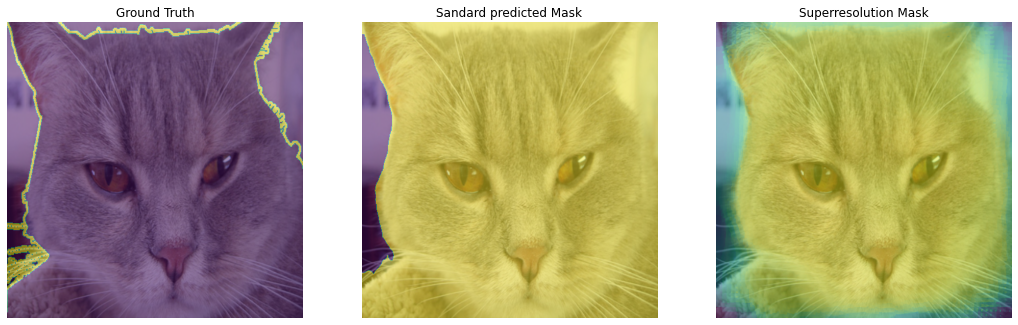

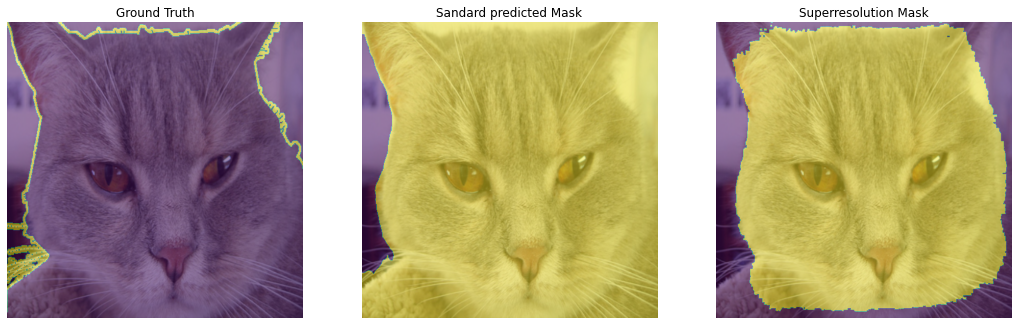

(0.6381338670848543, 0.6783887098659743)

In [20]:
plot_standard_superres(sample_image, true_mask, sample_standard, sample_superres)
plot_standard_superres(sample_image, true_mask, sample_standard, sample_superres_th)
evaluate_IOU(true_mask, sample_standard, sample_superres_th)

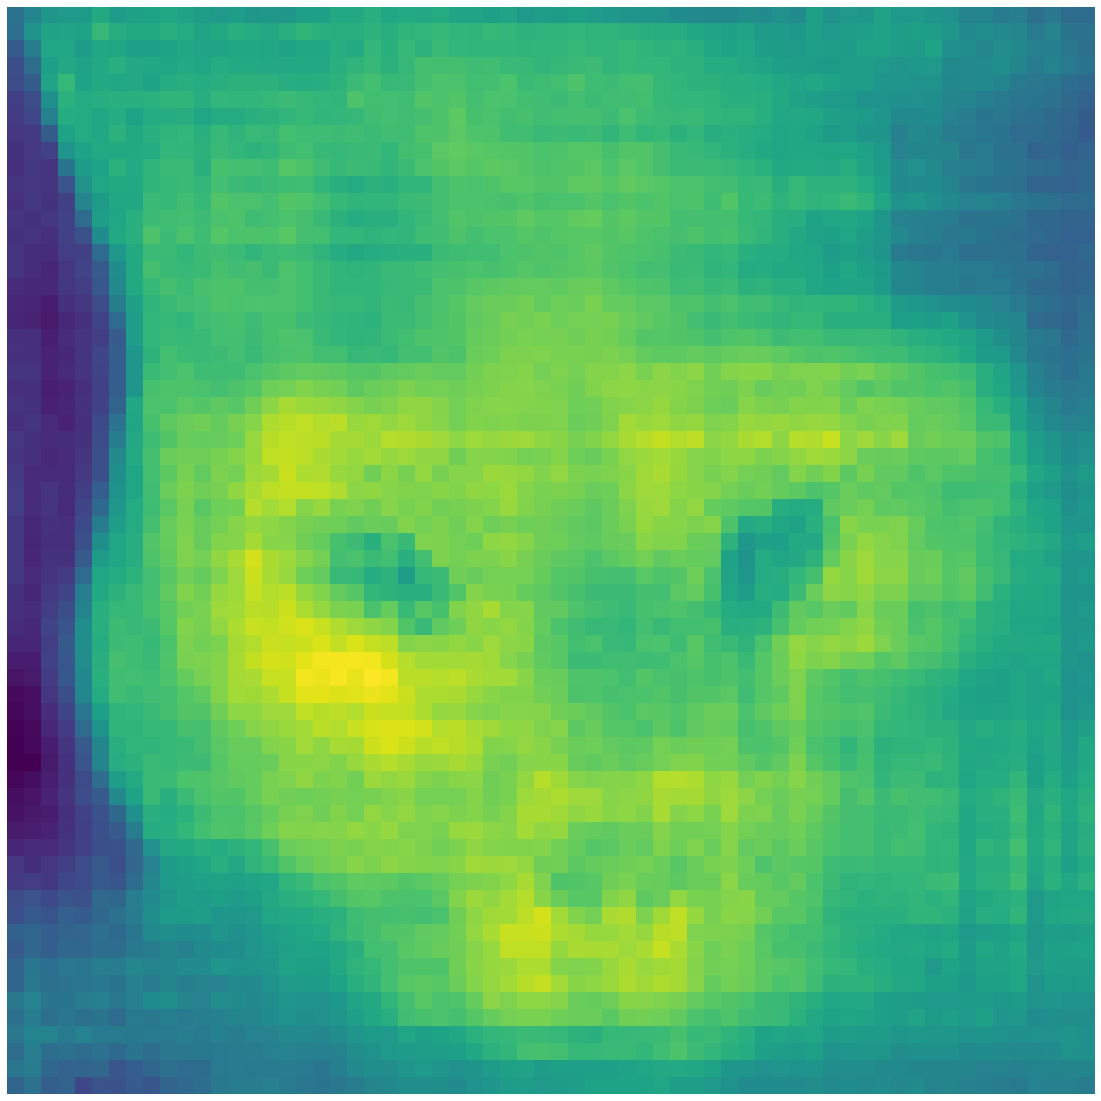

In [25]:
plot_image(augmented_features_dict[sample_key][0])

In [24]:
#plt.figure(figsize=(40, 40))
#ax = sns.heatmap(sample_superres_th[:, :, 0], annot=True, cbar=False, fmt=".2f

In [26]:
t = augmented_features_dict[sample_key][0]
t.max()

36.454712

In [29]:
np.max(augmented_features_dict[sample_key])

39.053856